In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import scipy.stats as sciStat
import time

import sussix

# Creating dummy signal
#==============================================
N  = np.arange(int(1e5))
Q0 = 0.31025793875089835
Qs = 0.002
dQ = Qs/12
Jx = (0.5*(10**2))

n_bands_Qs = 1
n_bands_dQ = 5
i,j    = np.arange(-n_bands_dQ,n_bands_dQ+1),np.arange(-n_bands_Qs,n_bands_Qs+1)
Ai,Aj  = sciStat.cauchy.pdf(i/np.max(i),0,0.05),sciStat.cauchy.pdf(j/np.max(j),0,0.05)
Ai,Aj  = Ai/np.max(Ai),Aj/np.max(Aj)

amplitudes  = np.array([[ (np.sqrt(2*Jx)*_Ai*_Aj) for _i,_Ai in zip(i,Ai) ] for _j,_Aj in zip(j,Aj) ]).flatten()
frequencies = np.array([[Q0+ _j*Qs + _i*dQ for _i,_Ai in zip(i,Ai) ] for _j,_Aj in zip(j,Aj) ]).flatten() 

expected = pd.DataFrame({'amplitude':amplitudes,'frequency':frequencies})
expected.sort_values(by='amplitude',ascending=False,inplace=True)
expected.reset_index(drop=True,inplace=True)

x,px    = sussix.analysis.generate_signal(expected.amplitude,expected.frequency,N)
#==============================================



---
# SUSSIX
---

(2e-06, 100.0)

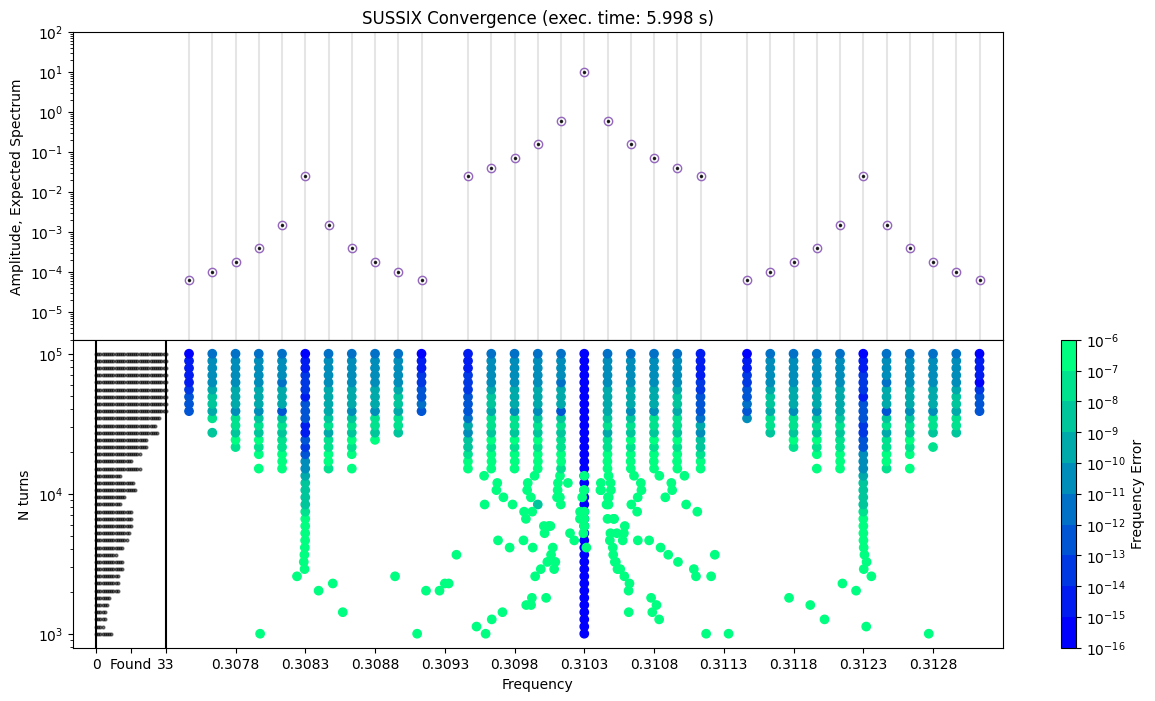

In [3]:

N_vec = np.logspace(3,5,40).astype(int)
freq_df = []
err_df = []
exc_df = []
t1 = time.perf_counter()
for N in N_vec:
    results = sussix.get_harmonics( x       = x[:N], 
                                    px      = px[:N],
                                    number_of_harmonics = len(expected),Hann_order = 2)

    # Finding matching line, higher weight on the frequency.
    tol_amp  = 1e0
    found = results['x'].copy()
    found.amplitude = found.amplitude.abs()
    found.insert(0,'match',np.nan)
    for line in found.index:
        distance = 0.2*(expected['amplitude']-found.loc[line,'amplitude'])**2 + 0.8*(expected['frequency']-found.loc[line,'frequency'])**2
        if np.sqrt(distance.min())/found.loc[line,'amplitude'] <1e-1 :
            found.loc[line,'match'] = int(distance.idxmin())

    # Creating frequency and amplitude table
    df_f   = pd.DataFrame({f'freq:{i}':[np.nan] for i in expected.index},index=[N])
    df_err = pd.DataFrame({f'Err:{i}':[np.nan] for i in expected.index},index=[N])
    exc_count = 0
    for idx,row in found.iterrows():
        if not pd.isna(row['match']):
            df_f.loc[N,f'freq:{row["match"]:.0f}']   = row['frequency']
            df_err.loc[N,f'Err:{row["match"]:.0f}']  = np.abs(row['frequency']-expected.loc[row["match"]].frequency)
            # df_err.loc[N,f'Err:{row["match"]:.0f}']  = np.abs(row['amplitude']-expected.loc[row["match"]].amplitude)/expected.loc[row["match"]].amplitude
        else:
            exc_count += 1
    df_exc =  pd.DataFrame({f'excluded':[exc_count] for i in expected.index},index=[N])
    df_err[df_err == 0] = 1e-21

    # saving results
    freq_df.append(df_f)
    err_df.append(df_err)
    exc_df.append(df_exc)
t2 = time.perf_counter()

# print(f'Elapsed time: {t2-t1:.3f} s')

df_freq = pd.concat(freq_df)
df_err  = pd.concat(err_df)
df_exc  = pd.concat(exc_df)





# PLOTTING
import matplotlib.colors as colors
vmin = 1e-16
vmax = 1e-6
fig, axs = plt.subplots(2, 1,figsize=(15,8))
plt.subplots_adjust(hspace=0)

plt.sca(axs[1])
bounds = np.array([1e-16,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
# norm = colors.LogNorm(vmin=vmin, vmax=vmax)
axs[0].set_title(f'SUSSIX Convergence (exec. time: {t2-t1:.3f} s)')
for col in df_freq.columns:
    idx = col.split(':')[-1]
    plt.scatter(df_freq[col],df_freq.index,c=df_err[f'Err:{idx}'],norm=norm,
                                                                cmap='winter')
cbar = plt.colorbar(label='Frequency Error',ticks=bounds)
cbar.ax.set_yticklabels([f'$10^{{{int(np.log10(b))}}}$' for b in bounds]) 

# Adding excluded points

x_exc_template = np.linspace(expected.frequency.min()-4*dQ,expected.frequency.min()-dQ,len(expected))
x_exec = np.array([list(x_exc_template[:len(expected)-row['excluded']]) + (row['excluded'])*[np.nan] for idx,row in df_exc.iterrows()])
y_exec = np.array([len(expected)*[idx] for idx,row in df_exc.iterrows()])

plt.plot(x_exec.flatten(),y_exec.flatten(),'o',ms=2,color='k',alpha=0.5)
plt.axvline(x_exc_template.max(),color='k')
plt.axvline(x_exc_template.min(),color='k')

plt.yscale('log')
plt.xlim(expected.frequency.min()-5*dQ,expected.frequency.max()+dQ)
plt.xlabel('Frequency')
plt.ylabel('N turns')
xticks = [x_exc_template.min(),x_exc_template.mean(),x_exc_template.max()] + list(np.linspace(Q0-15*dQ,Q0+15*dQ,11)) 
plt.gca().set_xticks(xticks,['0','Found',str(len(expected))] + [f'{_x:.4f}' for _x in xticks[3:]]);


plt.sca(axs[0])
plt.plot(expected.frequency,expected.amplitude,'o',color='C4',alpha=1,mfc='none')
plt.plot(expected.frequency,expected.amplitude,'.',color='k',alpha=0.8,ms=3)
plt.scatter(np.nan,np.nan)
cbar = plt.colorbar()
cbar.ax.set_visible(False)
plt.xticks([])

plt.yscale('log')
plt.xlim(Q0-10*Qs,Q0+10*Qs)
plt.ylabel('Amplitude, Expected Spectrum')
plt.xlim(expected.frequency.min()-5*dQ,expected.frequency.max()+dQ)
for line in expected.frequency:
    plt.axvline(line,color='k',alpha=0.1,zorder=-10)
plt.ylim(2e-6,1e2)

--- 
# NAFFlib
---

(2e-06, 100.0)

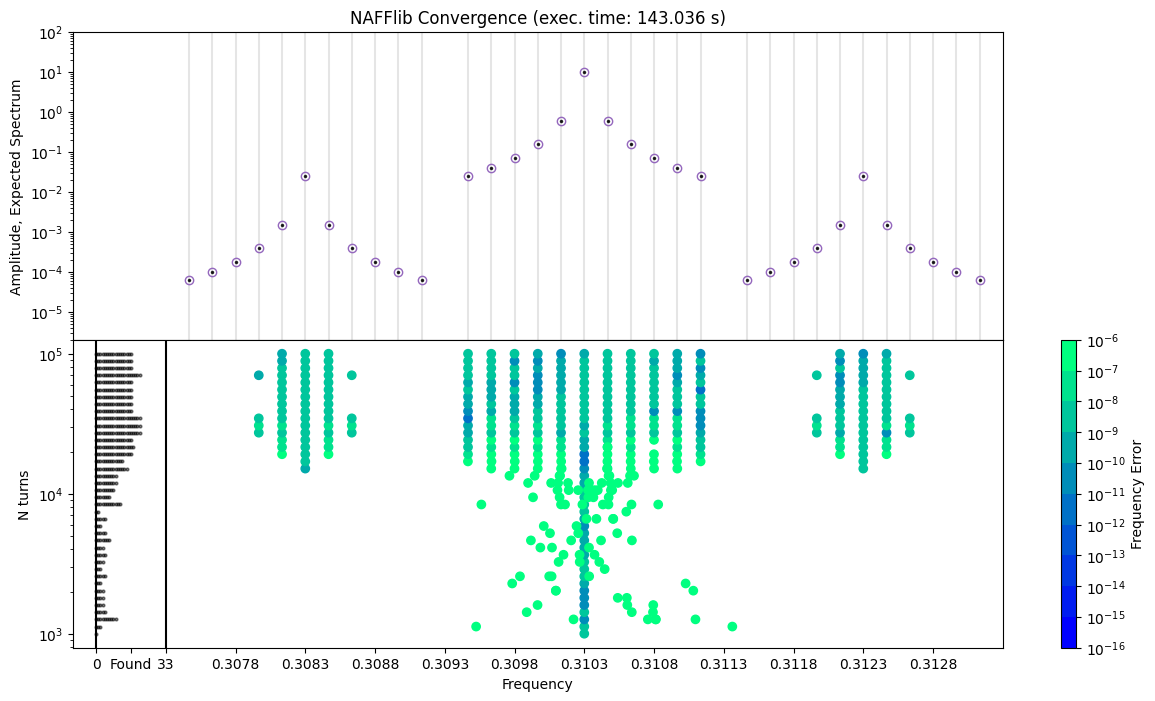

In [7]:
import NAFFlib
import gc
import importlib

N_vec = np.logspace(3,5,40).astype(int)
freq_df = []
err_df = []
exc_df = []
t1 = time.perf_counter()
for N in N_vec:

    # Need to reload the module to avoid weird freezing (NAFFlib problem)
    importlib.reload(NAFFlib)
    

    def NAFFlib_tune(x,nfreqs = 1,Hann_order=1):
            x        = np.array(x)
            Q,A,An  = NAFFlib.get_tunes(x, nfreqs, Hann_order)

            if nfreqs ==1:
                return Q[0]
            else:
                
                return Q,np.abs(A)
            
    naff_Q,naff_A = NAFFlib_tune(x[:N]-1j*px[:N],nfreqs=len(expected),Hann_order=2)
    naff_results = pd.DataFrame({'amplitude':naff_A,'frequency':naff_Q})

    del(naff_Q)
    del(naff_A)
    gc.collect()

    # Finding matching line, higher weight on the frequency.
    tol_amp  = 1e0
    found = naff_results.copy()
    found.amplitude = found.amplitude.abs()
    found.insert(0,'match',np.nan)
    for line in found.index:
        distance = 0.2*(expected['amplitude']-found.loc[line,'amplitude'])**2 + 0.8*(expected['frequency']-found.loc[line,'frequency'])**2
        if np.sqrt(distance.min())/found.loc[line,'amplitude'] <1e-1 :
            found.loc[line,'match'] = int(distance.idxmin())

    # Creating frequency and amplitude table
    df_f   = pd.DataFrame({f'freq:{i}':[np.nan] for i in expected.index},index=[N])
    df_err = pd.DataFrame({f'Err:{i}':[np.nan] for i in expected.index},index=[N])
    exc_count = 0
    for idx,row in found.iterrows():
        if not pd.isna(row['match']):
            df_f.loc[N,f'freq:{row["match"]:.0f}']   = row['frequency']
            df_err.loc[N,f'Err:{row["match"]:.0f}']  = np.abs(row['frequency']-expected.loc[row["match"]].frequency)
            # df_err.loc[N,f'Err:{row["match"]:.0f}']  = np.abs(row['amplitude']-expected.loc[row["match"]].amplitude)/expected.loc[row["match"]].amplitude
        else:
            exc_count += 1
    df_exc =  pd.DataFrame({f'excluded':[exc_count] for i in expected.index},index=[N])
    df_err[df_err == 0] = 1e-21

    # saving results
    freq_df.append(df_f)
    err_df.append(df_err)
    exc_df.append(df_exc)
t2 = time.perf_counter()

# print(f'Elapsed time: {t2-t1:.3f} s')

df_freq = pd.concat(freq_df)
df_err  = pd.concat(err_df)
df_exc  = pd.concat(exc_df)





# PLOTTING
import matplotlib.colors as colors
vmin = 1e-16
vmax = 1e-6
fig, axs = plt.subplots(2, 1,figsize=(15,8))
plt.subplots_adjust(hspace=0)

plt.sca(axs[1])
bounds = np.array([1e-16,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
# norm = colors.LogNorm(vmin=vmin, vmax=vmax)
axs[0].set_title(f'NAFFlib Convergence (exec. time: {t2-t1:.3f} s)')
for col in df_freq.columns:
    idx = col.split(':')[-1]
    plt.scatter(df_freq[col],df_freq.index,c=df_err[f'Err:{idx}'],norm=norm,
                                                                cmap='winter')
cbar = plt.colorbar(label='Frequency Error',ticks=bounds)
cbar.ax.set_yticklabels([f'$10^{{{int(np.log10(b))}}}$' for b in bounds]) 

# Adding excluded points

x_exc_template = np.linspace(expected.frequency.min()-4*dQ,expected.frequency.min()-dQ,len(expected))
x_exec = np.array([list(x_exc_template[:len(expected)-row['excluded']]) + (row['excluded'])*[np.nan] for idx,row in df_exc.iterrows()])
y_exec = np.array([len(expected)*[idx] for idx,row in df_exc.iterrows()])

plt.plot(x_exec.flatten(),y_exec.flatten(),'o',ms=2,color='k',alpha=0.5)
plt.axvline(x_exc_template.max(),color='k')
plt.axvline(x_exc_template.min(),color='k')

plt.yscale('log')
plt.xlim(expected.frequency.min()-5*dQ,expected.frequency.max()+dQ)
plt.xlabel('Frequency')
plt.ylabel('N turns')
xticks = [x_exc_template.min(),x_exc_template.mean(),x_exc_template.max()] + list(np.linspace(Q0-15*dQ,Q0+15*dQ,11)) 
plt.gca().set_xticks(xticks,['0','Found',str(len(expected))] + [f'{_x:.4f}' for _x in xticks[3:]]);


plt.sca(axs[0])
plt.plot(expected.frequency,expected.amplitude,'o',color='C4',alpha=1,mfc='none')
plt.plot(expected.frequency,expected.amplitude,'.',color='k',alpha=0.8,ms=3)
plt.scatter(np.nan,np.nan)
cbar = plt.colorbar()
cbar.ax.set_visible(False)
plt.xticks([])

plt.yscale('log')
plt.xlim(Q0-10*Qs,Q0+10*Qs)
plt.ylabel('Amplitude, Expected Spectrum')
plt.xlim(expected.frequency.min()-5*dQ,expected.frequency.max()+dQ)
for line in expected.frequency:
    plt.axvline(line,color='k',alpha=0.1,zorder=-10)
plt.ylim(2e-6,1e2)

---
# With a less dense spectrum, convergence is obviously better!
---

/Users/pbelanger/ABPLocal/BBStudies/Executables/miniforge3/envs/py-BB/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(2e-06, 100.0)

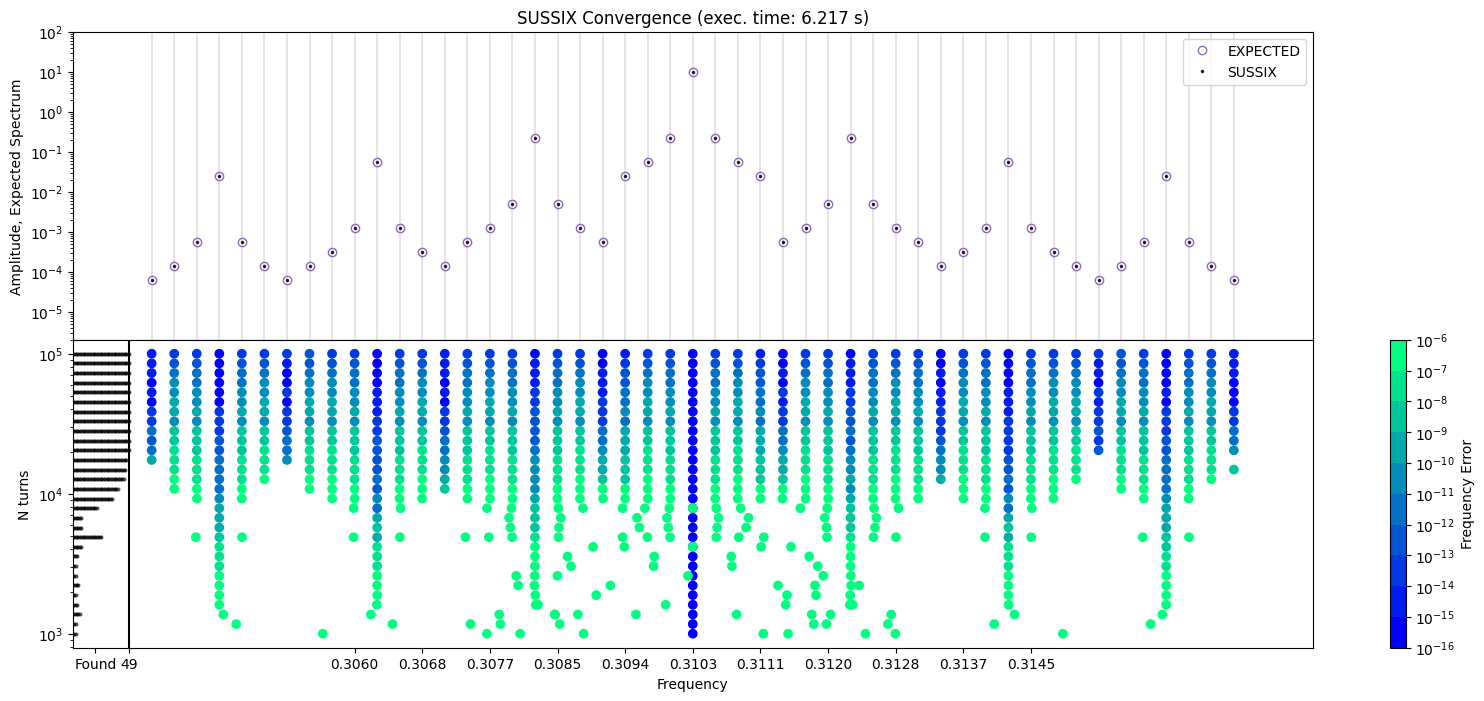

In [44]:
# Creating dummy signal
#==============================================
N  = np.arange(int(1e5))
Q0 = 0.31025793875089835
Qs = 0.002
dQ = Qs/7
Jx = (0.5*(10**2))

n_bands_Qs = 3
n_bands_dQ = 3
i,j    = np.arange(-n_bands_dQ,n_bands_dQ+1),np.arange(-n_bands_Qs,n_bands_Qs+1)
Ai,Aj  = sciStat.cauchy.pdf(i/np.max(i),0,0.05),sciStat.cauchy.pdf(j/np.max(j),0,0.05)
Ai,Aj  = Ai/np.max(Ai),Aj/np.max(Aj)

amplitudes  = np.array([[ (np.sqrt(2*Jx)*_Ai*_Aj) for _i,_Ai in zip(i,Ai) ] for _j,_Aj in zip(j,Aj) ]).flatten()
frequencies = np.array([[Q0+ _j*Qs + _i*dQ for _i,_Ai in zip(i,Ai) ] for _j,_Aj in zip(j,Aj) ]).flatten() 

expected = pd.DataFrame({'amplitude':amplitudes,'frequency':frequencies})
expected.sort_values(by='amplitude',ascending=False,inplace=True)
expected.reset_index(drop=True,inplace=True)

x,px    = sussix.analysis.generate_signal(expected.amplitude,expected.frequency,N)
#==============================================



N_vec = np.logspace(3,5,30).astype(int)
freq_df = []
err_df = []
exc_df = []
t1 = time.perf_counter()
for N in N_vec:
    results = sussix.get_harmonics( x       = x[:N], 
                                    px      = px[:N],
                                    number_of_harmonics = len(expected),Hann_order = 2)

    # Finding matching line, higher weight on the frequency.
    tol_amp  = 1e0
    found = results['x'].copy()
    found.amplitude = found.amplitude.abs()
    found.insert(0,'match',np.nan)
    for line in found.index:
        distance = 0.2*(expected['amplitude']-found.loc[line,'amplitude'])**2 + 0.8*(expected['frequency']-found.loc[line,'frequency'])**2
        if np.sqrt(distance.min())/found.loc[line,'amplitude'] <1e-1 :
            found.loc[line,'match'] = int(distance.idxmin())

    # Creating frequency and amplitude table
    df_f   = pd.DataFrame({f'freq:{i}':[np.nan] for i in expected.index},index=[N])
    df_err = pd.DataFrame({f'Err:{i}':[np.nan] for i in expected.index},index=[N])
    exc_count = 0
    for idx,row in found.iterrows():
        if not pd.isna(row['match']):
            df_f.loc[N,f'freq:{row["match"]:.0f}']   = row['frequency']
            df_err.loc[N,f'Err:{row["match"]:.0f}']  = np.abs(row['frequency']-expected.loc[row["match"]].frequency)
            # df_err.loc[N,f'Err:{row["match"]:.0f}']  = np.abs(row['amplitude']-expected.loc[row["match"]].amplitude)/expected.loc[row["match"]].amplitude
        else:
            exc_count += 1
    df_exc =  pd.DataFrame({f'excluded':[exc_count] for i in expected.index},index=[N])
    df_err[df_err == 0] = 1e-21

    # saving results
    freq_df.append(df_f)
    err_df.append(df_err)
    exc_df.append(df_exc)
t2 = time.perf_counter()

# print(f'Elapsed time: {t2-t1:.3f} s')

df_freq = pd.concat(freq_df)
df_err  = pd.concat(err_df)
df_exc  = pd.concat(exc_df)





# PLOTTING
import matplotlib.colors as colors
vmin = 1e-16
vmax = 1e-6
fig, axs = plt.subplots(2, 1,figsize=(20,8))
plt.subplots_adjust(hspace=0)

plt.sca(axs[1])
bounds = np.array([1e-16,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
# norm = colors.LogNorm(vmin=vmin, vmax=vmax)
axs[0].set_title(f'SUSSIX Convergence (exec. time: {t2-t1:.3f} s)')
for col in df_freq.columns:
    idx = col.split(':')[-1]
    plt.scatter(df_freq[col],df_freq.index,c=df_err[f'Err:{idx}'],norm=norm,
                                                                cmap='winter')
cbar = plt.colorbar(label='Frequency Error',ticks=bounds)
cbar.ax.set_yticklabels([f'$10^{{{int(np.log10(b))}}}$' for b in bounds]) 

# Adding excluded points

x_exc_template = np.linspace(expected.frequency.min()-4*dQ,expected.frequency.min()-dQ,len(expected))
x_exec = np.array([list(x_exc_template[:len(expected)-row['excluded']]) + (row['excluded'])*[np.nan] for idx,row in df_exc.iterrows()])
y_exec = np.array([len(expected)*[idx] for idx,row in df_exc.iterrows()])

plt.plot(x_exec.flatten(),y_exec.flatten(),'o',ms=2,color='k',alpha=0.5)
plt.axvline(x_exc_template.max(),color='k')
plt.axvline(x_exc_template.min(),color='k')

plt.yscale('log')

plt.xlabel('Frequency')
plt.ylabel('N turns')
xticks = [x_exc_template.min(),x_exc_template.mean(),x_exc_template.max()] + list(np.linspace(Q0-15*dQ,Q0+15*dQ,11)) 
plt.gca().set_xticks(xticks,['0','Found',str(len(expected))] + [f'{_x:.4f}' for _x in xticks[3:]]);

plt.xlim(expected.frequency.min()-(n_bands_Qs/2-1)*Qs,expected.frequency.max()+(n_bands_Qs/2-1)*Qs)

plt.sca(axs[0])
plt.plot(expected.frequency,expected.amplitude,'o',color='C4',alpha=1,mfc='none',label='EXPECTED')
plt.plot(results['x'].frequency,results['x'].amplitude,'.',color='k',alpha=0.8,ms=3,label='SUSSIX')
plt.scatter(np.nan,np.nan)
plt.legend()
cbar = plt.colorbar()
cbar.ax.set_visible(False)
plt.xticks([])

plt.yscale('log')
# plt.xlim(Q0-10*Qs,Q0+10*Qs)
plt.ylabel('Amplitude, Expected Spectrum')
plt.xlim(expected.frequency.min()-(n_bands_Qs/2-1)*Qs,expected.frequency.max()+(n_bands_Qs/2-1)*Qs)
for line in expected.frequency:
    plt.axvline(line,color='k',alpha=0.1,zorder=-10)
plt.ylim(2e-6,1e2)

/Users/pbelanger/ABPLocal/BBStudies/Executables/miniforge3/envs/py-BB/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(2e-06, 100.0)

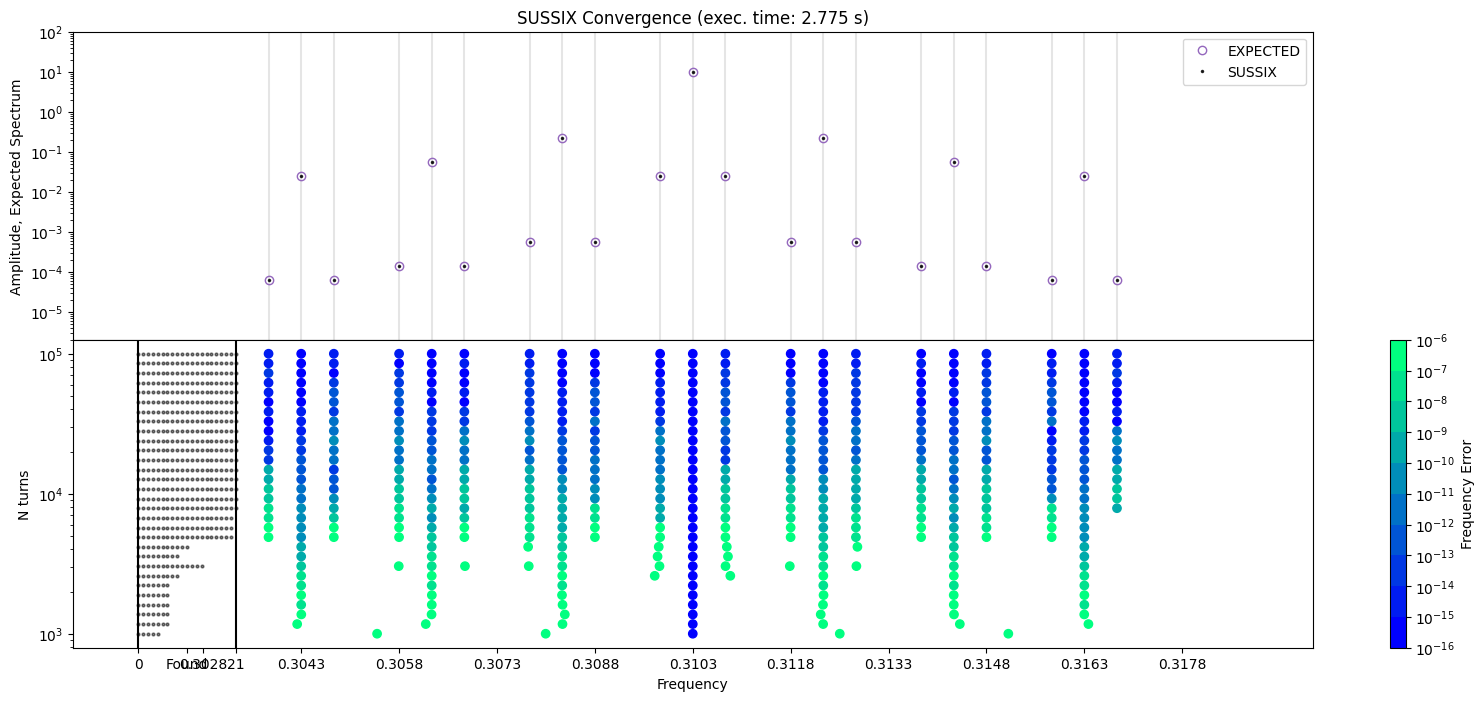

In [48]:
# Creating dummy signal
#==============================================
N  = np.arange(int(1e5))
Q0 = 0.31025793875089835
Qs = 0.002
dQ = Qs/4
Jx = (0.5*(10**2))

n_bands_Qs = 3
n_bands_dQ = 1
i,j    = np.arange(-n_bands_dQ,n_bands_dQ+1),np.arange(-n_bands_Qs,n_bands_Qs+1)
Ai,Aj  = sciStat.cauchy.pdf(i/np.max(i),0,0.05),sciStat.cauchy.pdf(j/np.max(j),0,0.05)
Ai,Aj  = Ai/np.max(Ai),Aj/np.max(Aj)
# Aj *=0

amplitudes  = np.array([[ (np.sqrt(2*Jx)*_Ai*_Aj) for _i,_Ai in zip(i,Ai) ] for _j,_Aj in zip(j,Aj) ]).flatten()
frequencies = np.array([[Q0+ _j*Qs + _i*dQ for _i,_Ai in zip(i,Ai) ] for _j,_Aj in zip(j,Aj) ]).flatten() 

expected = pd.DataFrame({'amplitude':amplitudes,'frequency':frequencies})
expected.sort_values(by='amplitude',ascending=False,inplace=True)
expected.reset_index(drop=True,inplace=True)

x,px    = sussix.analysis.generate_signal(expected.amplitude,expected.frequency,N)
#==============================================



N_vec = np.logspace(3,5,30).astype(int)
freq_df = []
err_df = []
exc_df = []
t1 = time.perf_counter()
for N in N_vec:
    results = sussix.get_harmonics( x       = x[:N], 
                                    px      = px[:N],
                                    number_of_harmonics = len(expected),Hann_order = 2)

    # Finding matching line, higher weight on the frequency.
    tol_amp  = 1e0
    found = results['x'].copy()
    found.amplitude = found.amplitude.abs()
    found.insert(0,'match',np.nan)
    for line in found.index:
        distance = 0.2*(expected['amplitude']-found.loc[line,'amplitude'])**2 + 0.8*(expected['frequency']-found.loc[line,'frequency'])**2
        if np.sqrt(distance.min())/found.loc[line,'amplitude'] <1e-1 :
            found.loc[line,'match'] = int(distance.idxmin())

    # Creating frequency and amplitude table
    df_f   = pd.DataFrame({f'freq:{i}':[np.nan] for i in expected.index},index=[N])
    df_err = pd.DataFrame({f'Err:{i}':[np.nan] for i in expected.index},index=[N])
    exc_count = 0
    for idx,row in found.iterrows():
        if not pd.isna(row['match']):
            df_f.loc[N,f'freq:{row["match"]:.0f}']   = row['frequency']
            df_err.loc[N,f'Err:{row["match"]:.0f}']  = np.abs(row['frequency']-expected.loc[row["match"]].frequency)
            # df_err.loc[N,f'Err:{row["match"]:.0f}']  = np.abs(row['amplitude']-expected.loc[row["match"]].amplitude)/expected.loc[row["match"]].amplitude
        else:
            exc_count += 1
    df_exc =  pd.DataFrame({f'excluded':[exc_count] for i in expected.index},index=[N])
    df_err[df_err == 0] = 1e-21

    # saving results
    freq_df.append(df_f)
    err_df.append(df_err)
    exc_df.append(df_exc)
t2 = time.perf_counter()

# print(f'Elapsed time: {t2-t1:.3f} s')

df_freq = pd.concat(freq_df)
df_err  = pd.concat(err_df)
df_exc  = pd.concat(exc_df)





# PLOTTING
import matplotlib.colors as colors
vmin = 1e-16
vmax = 1e-6
fig, axs = plt.subplots(2, 1,figsize=(20,8))
plt.subplots_adjust(hspace=0)

plt.sca(axs[1])
bounds = np.array([1e-16,1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
# norm = colors.LogNorm(vmin=vmin, vmax=vmax)
axs[0].set_title(f'SUSSIX Convergence (exec. time: {t2-t1:.3f} s)')
for col in df_freq.columns:
    idx = col.split(':')[-1]
    plt.scatter(df_freq[col],df_freq.index,c=df_err[f'Err:{idx}'],norm=norm,
                                                                cmap='winter')
cbar = plt.colorbar(label='Frequency Error',ticks=bounds)
cbar.ax.set_yticklabels([f'$10^{{{int(np.log10(b))}}}$' for b in bounds]) 

# Adding excluded points

x_exc_template = np.linspace(expected.frequency.min()-4*dQ,expected.frequency.min()-dQ,len(expected))
x_exec = np.array([list(x_exc_template[:len(expected)-row['excluded']]) + (row['excluded'])*[np.nan] for idx,row in df_exc.iterrows()])
y_exec = np.array([len(expected)*[idx] for idx,row in df_exc.iterrows()])

plt.plot(x_exec.flatten(),y_exec.flatten(),'o',ms=2,color='k',alpha=0.5)
plt.axvline(x_exc_template.max(),color='k')
plt.axvline(x_exc_template.min(),color='k')

plt.yscale('log')

plt.xlabel('Frequency')
plt.ylabel('N turns')
xticks = [x_exc_template.min(),x_exc_template.mean(),x_exc_template.max()] + list(np.linspace(Q0-15*dQ,Q0+15*dQ,11)) 
plt.gca().set_xticks(xticks,['0','Found',str(len(expected))] + [f'{_x:.4f}' for _x in xticks[3:]]);

plt.xlim(expected.frequency.min()-(n_bands_Qs/2)*Qs,expected.frequency.max()+(n_bands_Qs/2)*Qs)


plt.sca(axs[0])
plt.plot(expected.frequency,expected.amplitude,'o',color='C4',alpha=1,mfc='none',label='EXPECTED')
plt.plot(results['x'].frequency,results['x'].amplitude,'.',color='k',alpha=0.8,ms=3,label='SUSSIX')
plt.scatter(np.nan,np.nan)
plt.legend()
cbar = plt.colorbar()
cbar.ax.set_visible(False)
plt.xticks([])

plt.yscale('log')
# plt.xlim(Q0-10*Qs,Q0+10*Qs)
plt.ylabel('Amplitude, Expected Spectrum')
plt.xlim(expected.frequency.min()-(n_bands_Qs/2)*Qs,expected.frequency.max()+(n_bands_Qs/2)*Qs)
for line in expected.frequency:
    plt.axvline(line,color='k',alpha=0.1,zorder=-10)
plt.ylim(2e-6,1e2)